<h1>Classification using GBDT models (xgboost/lightgbm) </h1>

## 1.1 Loading Data

In [1]:
import pickle
from tqdm.notebook import tqdm 
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Normalizer
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
#from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgm

from scipy.sparse import hstack
from scipy import sparse

import nltk
# nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#from wordcloud import WordCloud

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('preprocessed_data.csv')

In [3]:
data.head()

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74


In [4]:
feature_set = data.drop(columns=['project_is_approved'])
target_set = data['project_is_approved']

In [5]:
feature_set.head()

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,literacy_language,literacy,having class 24 students comes diverse learner...,329.00
3,ga,mrs,grades_prek_2,2,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74


In [6]:
target_set.head()

0    1
1    1
2    1
3    1
4    1
Name: project_is_approved, dtype: int64

<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [7]:
x_train, x_test, y_train, y_test = train_test_split(feature_set, target_set, test_size= 0.3, random_state= 46,stratify=target_set )

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)  

(76473, 8)
(32775, 8)
(76473,)
(32775,)


<h2>1.3 Make Data Model Ready: encoding eassay, and project_title</h2>

> TFIDF transformation of essay

In [8]:
features_of_tfidf = []

tfidf = TfidfVectorizer(min_df=100,ngram_range=(1,2))
tfidf.fit(x_train['essay'])

features_of_tfidf.extend(tfidf.get_feature_names())

In [9]:
tfidf_train_essay = tfidf.transform(x_train['essay'].values)
tfidf_test_essay = tfidf.transform(x_test['essay'].values)

print("Shape of matrix after TF-IDF -> Essay: x_train: ",tfidf_train_essay.shape)
print("Shape of matrix after TF-IDF -> Essay: x_test : ",tfidf_test_essay.shape)

Shape of matrix after TF-IDF -> Essay: x_train:  (76473, 17061)
Shape of matrix after TF-IDF -> Essay: x_test :  (32775, 17061)


> Word to Vec tranformation of essay

In [10]:
#please use below code to load glove vectors 
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words = set(model.keys())

In [11]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(x_train['essay'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [12]:
# average Word2Vec on train data
# compute average word2vec for each review.
tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(x_train['essay'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors.append(vector)

print(len(tfidf_w2v_vectors))
print(len(tfidf_w2v_vectors[0])) # no of features for each data-point(row)

  0%|          | 0/76473 [00:00<?, ?it/s]

76473
300


In [13]:
# average Word2Vec on test data
# compute average word2vec for each review.
tfidf_w2v_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(x_test['essay'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_test.append(vector)

print(len(tfidf_w2v_vectors_test))

  0%|          | 0/32775 [00:00<?, ?it/s]

32775


#### Sentiment analysis

In [14]:
sid = SentimentIntensityAnalyzer()

essay_train =x_train["essay"].values
essay_train_sentiment_score_pos = []
essay_train_sentiment_score_neg = []
essay_train_sentiment_score_neut = []
essay_train_sentiment_score_comp = []

for sentence in tqdm(essay_train):
    res = sid.polarity_scores(sentence)
    essay_train_sentiment_score_comp.append(res['compound'])
    essay_train_sentiment_score_neut.append(res['neu'])
    essay_train_sentiment_score_neg.append(res['neg'])
    essay_train_sentiment_score_pos.append(res['pos'])
    
x_train['essay_sentiment_train_pos'] = essay_train_sentiment_score_pos
x_train['essay_sentiment_train_neg'] = essay_train_sentiment_score_neg
x_train['essay_sentiment_train_neut'] = essay_train_sentiment_score_neut
x_train['essay_sentiment_train_comp'] = essay_train_sentiment_score_comp

x_train.head()

  0%|          | 0/76473 [00:00<?, ?it/s]

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price,essay_sentiment_train_pos,essay_sentiment_train_neg,essay_sentiment_train_neut,essay_sentiment_train_comp
59508,ca,ms,grades_prek_2,3,literacy_language,literacy literature_writing,our favorite booksare cherished minds hearts l...,219.00,0.382,0.000,0.618,0.9951
95319,wa,mrs,grades_3_5,10,music_arts,music,my students come farming community the communi...,719.99,0.335,0.013,0.652,0.9940
16725,mn,mrs,grades_3_5,6,literacy_language,esl literacy,our school little engine could our students co...,5.25,0.308,0.033,0.659,0.9914
4395,ne,mr,grades_prek_2,25,health_sports,teamsports,our students wonderfully gifted talented hard ...,184.01,0.320,0.011,0.669,0.9875
54632,ca,mrs,grades_6_8,2,literacy_language,literacy,our middle school students eager readers they ...,326.24,0.327,0.009,0.664,0.9930


In [15]:
sid = SentimentIntensityAnalyzer()

essay_test = x_test["essay"]
essay_test_sentiment_score_pos = []
essay_test_sentiment_score_neg = []
essay_test_sentiment_score_neut = []
essay_test_sentiment_score_comp = []


for sentence in tqdm(essay_test):
    res = sid.polarity_scores(sentence)
    essay_test_sentiment_score_comp.append(res['compound'])
    essay_test_sentiment_score_neut.append(res['neu'])
    essay_test_sentiment_score_neg.append(res['neg'])
    essay_test_sentiment_score_pos.append(res['pos'])
    
x_test['essay_sentiment_test_pos'] = essay_test_sentiment_score_pos
x_test['essay_sentiment_test_neg'] = essay_test_sentiment_score_neg
x_test['essay_sentiment_test_neut'] = essay_test_sentiment_score_neut
x_test['essay_sentiment_test_comp'] = essay_test_sentiment_score_comp

x_test.head()

  0%|          | 0/32775 [00:00<?, ?it/s]

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price,essay_sentiment_test_pos,essay_sentiment_test_neg,essay_sentiment_test_neut,essay_sentiment_test_comp
9048,il,ms,grades_6_8,4,literacy_language specialneeds,literacy specialneeds,students school embraced personalized learning...,31.97,0.411,0.043,0.546,0.9944
62328,sc,ms,grades_3_5,0,health_sports literacy_language,health_wellness literature_writing,my students come school day excited ready lear...,198.91,0.405,0.013,0.582,0.9960
59217,ut,ms,grades_3_5,1,literacy_language specialneeds,literacy specialneeds,my students range low functioning autistic kid...,419.36,0.194,0.058,0.748,0.9613
10805,fl,mrs,grades_prek_2,2,math_science,appliedsciences mathematics,my students curious group children ready explo...,379.45,0.360,0.017,0.623,0.9938
252,wa,mrs,grades_prek_2,7,literacy_language math_science,literacy mathematics,the desks need go as move toward working coope...,132.97,0.298,0.048,0.655,0.9950


In [16]:
#converting the column data into an independent feature

sentiment_test_pos = x_test['essay_sentiment_test_pos'].values.reshape(-1,1)
sentiment_test_neg = x_test['essay_sentiment_test_neg'].values.reshape(-1,1)
sentiment_test_neut = x_test['essay_sentiment_test_neut'].values.reshape(-1,1)
sentiment_test_comp = x_test['essay_sentiment_test_comp'].values.reshape(-1,1)

sentiment_train_pos = x_train['essay_sentiment_train_pos'].values.reshape(-1,1)
sentiment_train_neg = x_train['essay_sentiment_train_neg'].values.reshape(-1,1)
sentiment_train_neut = x_train['essay_sentiment_train_neut'].values.reshape(-1,1)
sentiment_train_comp = x_train['essay_sentiment_train_comp'].values.reshape(-1,1)

<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

> Encoding Numerical features

In [17]:
nv = Normalizer()

In [18]:
""" teacher_number_of_previously_posted_projects price """


nv.fit(x_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

teacher_number_of_previously_posted_projects_train_nv = nv.transform(x_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
teacher_number_of_previously_posted_projects_test_nv = nv.transform(x_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

nv.fit(x_train['price'].values.reshape(-1,1))

price_train_nv = nv.transform(x_train['price'].values.reshape(-1,1))
price_test_nv = nv.transform(x_test['price'].values.reshape(-1,1))

> Encoding categorical features using response coding

In [19]:
#Functions to perform response coding for handling categorical data

    #this function handles all the provided features of a dataset to return an intermediate response table in the form of a dictionary
def to_response_table(data, features, target):
    data['project_is_approved'] = target
    returning_dict = {}
    for feature in tqdm(features):
        uniq_values = data[feature].unique()
        temp_dict = {}
        for val in uniq_values:
            total_entries = len(data.loc[data[feature] == val])
            class_1_entries = len(data.loc[(data[feature] == val) & data['project_is_approved'] == 1])
            temp_dict[val] = class_1_entries/total_entries
        returning_dict[feature] = temp_dict
    return returning_dict

    #this function takses the response table and converts the response table to encoded data feature by feature
def transform_encoded_response(response_dict, feature, data):
    pos_feature_score = []
    neg_feature_score = []
    for val in data[feature].values:
        pos_score = response_dict[feature].get(val,0.5) # as if the feature not found the deafult values to be given as 0.5(laplace smoothening)
        neg_score = 1-pos_score
        pos_feature_score.append(pos_score)
        neg_feature_score.append(neg_score)
    return np.vstack( (np.asarray(pos_feature_score),np.asarray(neg_feature_score)) ).T
        

In [20]:
response_data = to_response_table(x_train, ['school_state', 'teacher_prefix' ,'project_grade_category', 'clean_categories' ,'clean_subcategories'],y_train)

  0%|          | 0/5 [00:00<?, ?it/s]

In [21]:
    #encoding categorical data for train dataset
school_state_train_resp = transform_encoded_response(response_data, 'school_state', x_train)
teacher_prefix_train_resp = transform_encoded_response(response_data, 'teacher_prefix', x_train)
project_grade_category_train_resp = transform_encoded_response(response_data, 'project_grade_category', x_train)
clean_categories_train_resp = transform_encoded_response(response_data, 'clean_categories', x_train)
clean_subcategories_train_resp = transform_encoded_response(response_data, 'clean_subcategories', x_train)

    #encoding categorical data for test dataset
school_state_test_resp = transform_encoded_response(response_data, 'school_state', x_test)
teacher_prefix_test_resp = transform_encoded_response(response_data, 'teacher_prefix', x_test)
project_grade_category_test_resp = transform_encoded_response(response_data, 'project_grade_category', x_test)
clean_categories_test_resp = transform_encoded_response(response_data, 'clean_categories', x_test)
clean_subcategories_test_resp = transform_encoded_response(response_data, 'clean_subcategories', x_test)

<li><font color='red'>Set 1</font>: categorical data-response coded, numerical features +  preprocessed_eassay (TFIDF)+sentiment Score of eassay</li>

In [22]:
tfidf_trainset = hstack((school_state_train_resp, teacher_prefix_train_resp, project_grade_category_train_resp, clean_categories_train_resp, clean_subcategories_train_resp, teacher_number_of_previously_posted_projects_train_nv, price_train_nv, tfidf_train_essay,sentiment_train_comp, sentiment_train_neg, sentiment_train_neut, sentiment_train_pos )).tocsr()

tfidf_testset = hstack((school_state_test_resp, teacher_prefix_test_resp, project_grade_category_test_resp, clean_categories_test_resp, clean_subcategories_test_resp, teacher_number_of_previously_posted_projects_test_nv, price_test_nv, tfidf_test_essay,sentiment_test_comp, sentiment_test_neg, sentiment_test_neut, sentiment_test_pos)).tocsr()


In [23]:
print(tfidf_trainset.shape)
print(tfidf_testset.shape)

(76473, 17077)
(32775, 17077)


<li><font color='red'>Set 2</font>: categorical data-response coded, numerical features +  preprocessed_eassay (TFIDF W2V)</li>        
    </li>

In [24]:
w2v_trainset = np.hstack((school_state_train_resp, teacher_prefix_train_resp, project_grade_category_train_resp, clean_categories_train_resp, clean_subcategories_train_resp, teacher_number_of_previously_posted_projects_train_nv, price_train_nv, tfidf_w2v_vectors))

w2v_testset = np.hstack((school_state_test_resp, teacher_prefix_test_resp, project_grade_category_test_resp, clean_categories_test_resp, clean_subcategories_test_resp, teacher_number_of_previously_posted_projects_test_nv, price_test_nv, tfidf_w2v_vectors_test))

In [25]:
print(w2v_trainset.shape)
print(w2v_testset.shape)

(76473, 312)
(32775, 312)


<h2>1.5 Appling Models on different kind of featurization</h2>

In [26]:
# xgb_model = xgb.XGBClassifier()
lgm_model = lgm.LGBMClassifier()

parameter = { "n_estimators": [50,100,200,300],"max_depth" : [10,20,30]}

grid_cv = GridSearchCV(lgm_model,parameter, n_jobs=-1, scoring='roc_auc',cv= 3,verbose=2,return_train_score=True)

grid_cv.fit(tfidf_trainset,y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3, estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30],
                         'n_estimators': [50, 100, 200, 300]},
             return_train_score=True, scoring='roc_auc', verbose=2)

In [27]:
print("Train Scores: "+ str(grid_cv.cv_results_['mean_train_score']))
print("CV Scores :" + str(grid_cv.cv_results_['mean_test_score']))

Train Scores: [0.82935145 0.88816115 0.94366103 0.96918434 0.83052021 0.89164901
 0.95211989 0.97899728 0.82892531 0.89043429 0.9524427  0.97929149]
CV Scores :[0.7041982  0.71280466 0.71697862 0.71728484 0.71068515 0.71900486
 0.72051869 0.71888485 0.71257858 0.7188989  0.71894121 0.71688813]


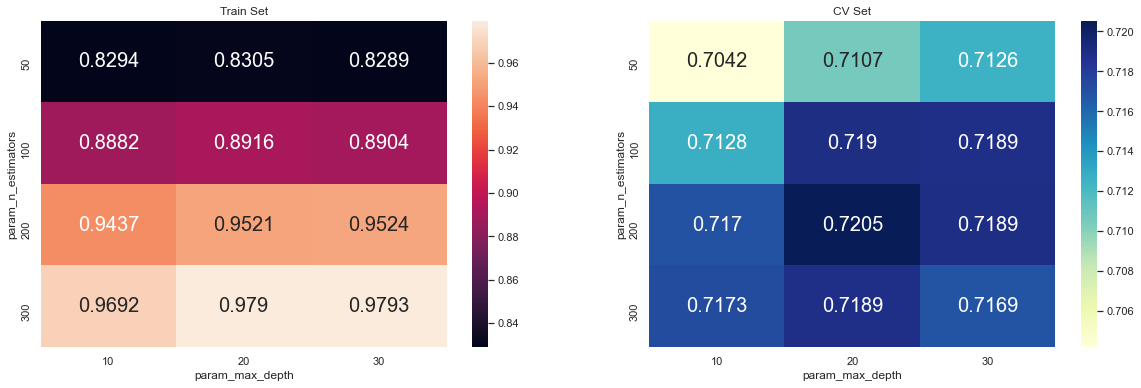

In [28]:
max_scores1 = pd.DataFrame(grid_cv.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0],annot_kws={"size": 20})
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1],annot_kws={"size": 20},cmap="YlGnBu")
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

In [32]:
print("BEST MAX DEPTH: ",grid_cv.best_params_['max_depth'],"\nBEST SCORE: ",grid_cv.best_score_,"\nBEST Estimator value: ",grid_cv.best_params_['n_estimators'])

BEST MAX DEPTH:  20 
BEST SCORE:  0.7205186929801425 
BEST Estimator value:  200


> Using best parameter to train the model

In [33]:
lgm_tfidf = lgm.LGBMClassifier(n_estimators= 200, max_depth=20)
lgm_tfidf.fit(tfidf_trainset,y_train)

LGBMClassifier(max_depth=20, n_estimators=200)

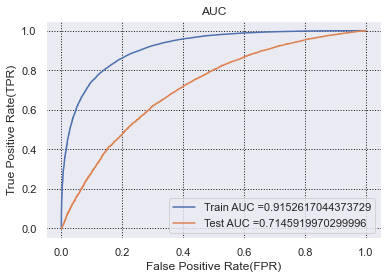

In [34]:
y_train_pred=lgm_tfidf.predict_proba(tfidf_trainset)[:,1]
y_test_pred=lgm_tfidf.predict_proba(tfidf_testset)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

# Plot the ROC-AUC curves using the probability predictions made on train and test data.
plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("AUC")
plt.grid(b=True, which='major', color='k', linestyle=':')
plt.show()

In [38]:
def predict(proba, t):
    #t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    #print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)

    return predictions

Train confusion matrix
[[ 9457  2122]
 [ 9854 55040]]


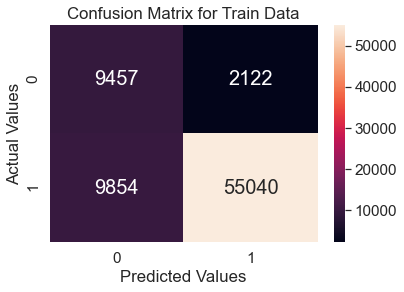

In [41]:
best_thres = tr_thresholds[np.argmax(train_tpr*(1-train_fpr))]

print("Train confusion matrix")
print(confusion_matrix(y_train, predict(y_train_pred, best_thres)))

conf_matr_df_train = pd.DataFrame(confusion_matrix(y_train, predict(y_train_pred, best_thres)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_train, annot=True,annot_kws={"size": 20}, fmt='g')

plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.title("Confusion Matrix for Train Data")
plt.show()

Test confusion matrix
[[ 2532  2431]
 [ 5735 22077]]


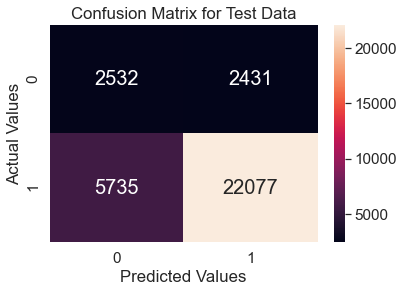

In [45]:
print("Test confusion matrix")
print(confusion_matrix(y_test, predict(y_test_pred, best_thres)))

conf_matr_df_train = pd.DataFrame(confusion_matrix(y_test, predict(y_test_pred, best_thres)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_train, annot=True,annot_kws={"size": 20}, fmt='g')

plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.title("Confusion Matrix for Test Data")
plt.show()

> Hyperparameter tuning for set2 

In [46]:
lgm_clf = lgm.LGBMClassifier()
parameter = { "n_estimators": [10,50,100,200,300],"max_depth" : [10,20,30,50]}

grid_cv = GridSearchCV(lgm_clf,parameter, n_jobs=-1, scoring='roc_auc',cv= 3,verbose=2,return_train_score=True)
grid_cv.fit(w2v_trainset,y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


GridSearchCV(cv=3, estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, 50],
                         'n_estimators': [10, 50, 100, 200, 300]},
             return_train_score=True, scoring='roc_auc', verbose=2)

In [47]:
print("Train Scores: "+ str(grid_cv.cv_results_['mean_train_score']))
print("CV Scores :" + str(grid_cv.cv_results_['mean_test_score']))

Train Scores: [0.7255866  0.82062813 0.89018516 0.9592194  0.98552899 0.7255866
 0.82090161 0.893289   0.96229541 0.98744446 0.7255866  0.82090161
 0.893289   0.96229541 0.98744446 0.7255866  0.82090161 0.893289
 0.96229541 0.98744446]
CV Scores :[0.66770782 0.69516843 0.69893958 0.69775617 0.69565851 0.66770782
 0.69374114 0.69630858 0.69513936 0.6940507  0.66770782 0.69374114
 0.69630858 0.69513936 0.6940507  0.66770782 0.69374114 0.69630858
 0.69513936 0.6940507 ]


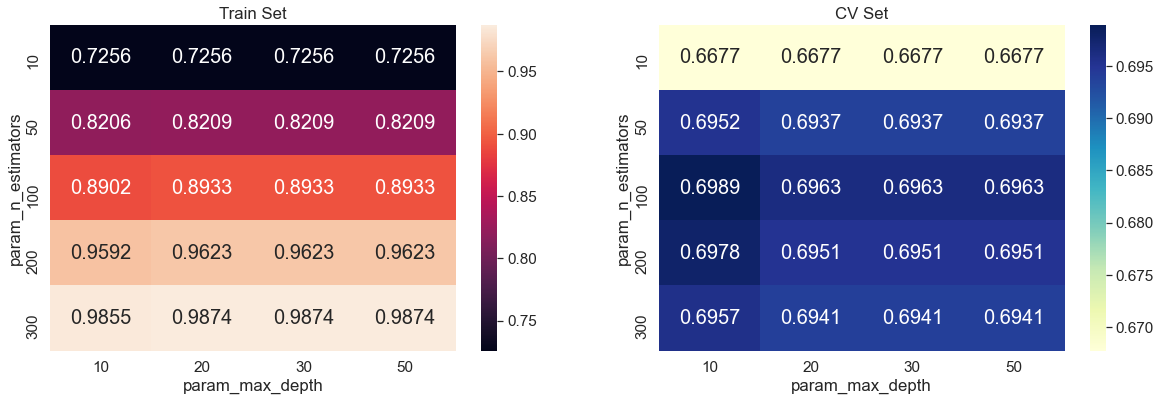

In [48]:
max_scores1 = pd.DataFrame(grid_cv.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0],annot_kws={"size": 20})
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1],annot_kws={"size": 20},cmap="YlGnBu")
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

In [49]:
print("BEST MAX DEPTH: ",grid_cv.best_params_['max_depth'],"\nBEST SCORE: ",grid_cv.best_score_,"\nBEST Estimator value: ",grid_cv.best_params_['n_estimators'])

BEST MAX DEPTH:  10 
BEST SCORE:  0.6989395777509584 
BEST Estimator value:  100


> Using best parameter to train the model

In [56]:
lgm_w2v = lgm.LGBMClassifier(n_estimators= 100, max_depth=10)
lgm_w2v.fit(w2v_trainset,y_train)

LGBMClassifier(max_depth=10)

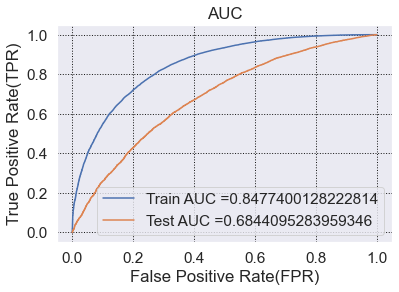

In [57]:
y_train_pred =lgm_w2v.predict_proba(w2v_trainset)[:,1]
y_test_pred =lgm_w2v.predict_proba(w2v_testset)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

# Plot the ROC-AUC curves using the probability predictions made on train and test data.
plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("AUC")
plt.grid(b=True, which='major', color='k', linestyle=':')
plt.show()

Train confusion matrix
[[ 8587  2992]
 [13714 51180]]


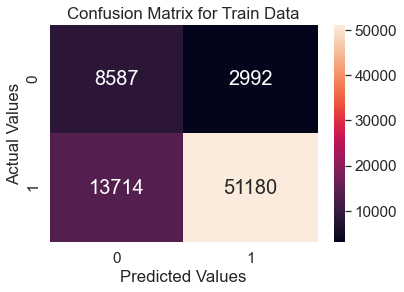

In [58]:
best_thres = tr_thresholds[np.argmax(train_tpr*(1-train_fpr))]

print("Train confusion matrix")
print(confusion_matrix(y_train, predict(y_train_pred, best_thres)))

conf_matr_df_train = pd.DataFrame(confusion_matrix(y_train, predict(y_train_pred, best_thres)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_train, annot=True,annot_kws={"size": 20}, fmt='g')

plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.title("Confusion Matrix for Train Data")
plt.show()

Test confusion matrix
[[ 2581  2382]
 [ 7124 20688]]


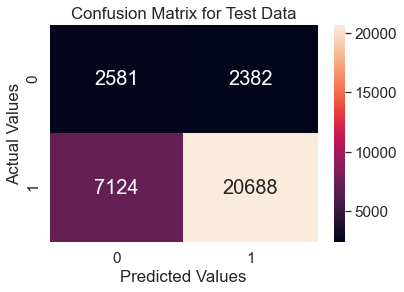

In [59]:
print("Test confusion matrix")
print(confusion_matrix(y_test, predict(y_test_pred, best_thres)))

conf_matr_df_train = pd.DataFrame(confusion_matrix(y_test, predict(y_test_pred, best_thres)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_train, annot=True,annot_kws={"size": 20}, fmt='g')

plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.title("Confusion Matrix for Test Data")
plt.show()

<h1>3. Summary</h1>


<h4>After implementation of XGBoost modle and LightGBM model, we can easily conclude taht the XGBoost model is way more time consuming. Hence the LightGBM model can be preffered if computational rtesources are limited.

In [60]:
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ["Vectorizer", "Model", "n_estimators","max_depth", "Train AUC", "Test AUC"]
table.add_row(["TFIDF + sentiment score", "XGBM using LightGBM model", 200,20, 0.9152,0.7146])
table.add_row(["Word to Vec", "XGBM using LightGBM model", 100,10, 0.8477,0.6844])


print(table)

+-------------------------+---------------------------+--------------+-----------+-----------+----------+
|        Vectorizer       |           Model           | n_estimators | max_depth | Train AUC | Test AUC |
+-------------------------+---------------------------+--------------+-----------+-----------+----------+
| TFIDF + sentiment score | XGBM using LightGBM model |     200      |     20    |   0.9152  |  0.7146  |
|       Word to Vec       | XGBM using LightGBM model |     100      |     10    |   0.8477  |  0.6844  |
+-------------------------+---------------------------+--------------+-----------+-----------+----------+
